## Importing necessary packages

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.mode.chained_assignment = None

## Reading data

In [2]:
# The accounts.csv contains a list of bank accounts, with the date of the last
# update of their financial data, and the balance on the account on the update date
accounts = pd.read_csv("../data/accounts.csv")

# The transactions.csv contains all available transactions on the accounts up
# to the update date, with an amount (in EUR) and the date of the day they were recorded.
transactions = pd.read_csv("../data/transactions.csv")

In [3]:
# Convert date columnns to date format
accounts["update_date"] = pd.to_datetime(accounts["update_date"])
transactions["date"] = pd.to_datetime(transactions["date"])

In [4]:
# Display some rows of accounts data
accounts

,id,balance,update_date
0,0,13.63,2021-07-02
1,1,12.91,2021-07-02
2,2,19.84,2021-07-02
3,3,130.00,2021-07-02
4,4,2806.75,2021-07-02
...,...,...,...
1249,1249,5117.09,2021-07-02
1250,1250,-2952.06,2021-07-02
1251,1251,361.86,2021-07-02
1252,1252,2074.71,2021-07-02


In [5]:
# Display some rows of transactions data
transactions

,account_id,date,amount
0,0,2020-10-16,200.0
1,0,2020-10-16,-192.0
2,0,2020-10-16,200.0
3,0,2020-10-16,-24.0
4,0,2020-10-16,-50.0
...,...,...,...
518224,1253,2020-10-25,-11.5
518225,1253,2020-10-26,-1.2
518226,1253,2020-10-31,-15.0
518227,1253,2020-11-03,-15.6


In [6]:
# Check if some accounts ids are repeated
accounts.id.nunique()

1254

No accounts ids are repeated in the accounts dataframe. However, this doesn't mean 
that we don't have duplicated datas. We will check this later. 

## Remove outliers

In [7]:
def remove_outliers(sigma_multiplier, column, df):
    """
    Removes datas outside the interval [mean-sigma_multiplier*std,mean+sigma_multiplier*std]
    and returns only datas inside this interval
    """
    med = np.median(df[column])
    std = np.std(df[column])

    return df[np.abs((df[column] - med)) <= sigma_multiplier * std]

In [8]:
transactions = remove_outliers(3, "amount", transactions)

In [9]:
accounts = remove_outliers(4, "balance", accounts)

We chose to sigma_multiplier=4 for accounts not to have high restrictions on accounts 
and to keep more accounts. 

## Merge dataframes and build new dataframe

In [10]:
# Merge accounts and transactions dataframes
df = pd.merge(accounts, transactions, how="inner", left_on="id", right_on="account_id")
df = df.drop(["account_id"], axis=1)

In [11]:
# Save new merged data set
df.to_csv("../data/accounts_transactions.csv", index=False)

## Check history accounts

In [12]:
# Read merged data
df = pd.read_csv(
    "../data/accounts_transactions.csv", index_col="date", parse_dates=True
)

In [13]:
# Display first rows of data
df.head()

,id,balance,update_date,amount
date,,,,
2020-10-16,0,13.63,2021-07-02,200.0
2020-10-16,0,13.63,2021-07-02,-192.0
2020-10-16,0,13.63,2021-07-02,200.0
2020-10-16,0,13.63,2021-07-02,-24.0
2020-10-16,0,13.63,2021-07-02,-50.0


In [14]:
# Convert update_date column to date format
df["update_date"] = pd.to_datetime(df["update_date"])

In [15]:
# Display information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508613 entries, 2020-10-16 to 2020-11-14
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           508613 non-null  int64         
 1   balance      508613 non-null  float64       
 2   update_date  508613 non-null  datetime64[ns]
 3   amount       508613 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 19.4 MB


In [16]:
# Any missing values?
df.isna().sum()

id             0
balance        0
update_date    0
amount         0
dtype: int64

In [17]:
# Display number of unique values in every column of df
for col in df:
    print(df[col].nunique())

1236
1057
1
58551


We have one unique update_date value for all transactions.

### Check that we have at least one transaction

In [18]:
df.shape[0] >= 1

True

### Check if Update Date is consistent with transaction dates

In [19]:
print(
    f"Update Date Inconsistent With Transaction Dates ? \
{((df['update_date']-df.index).dt.days < 0).any()}"
)

Update Date Inconsistent With Transaction Dates ? False


### Filter data by history days number

In [20]:
def history_accounts(df, history=180):

    """
    Returns accounts' indexes which have more than 180 
    days of history and accounts' indexes which have less
    than 180 days of history
    """
    kept_accounts = []
    rejected_accounts = []
    for index in df.id.unique():
        old = df[df["id"] == index].reset_index().date.iloc[0]
        new = df[df["id"] == index].reset_index().date.iloc[-1]
        duration = (new - old).days
        if duration >= history:
            kept_accounts.append(index)
        else:
            rejected_accounts.append(index)

    return (kept_accounts, rejected_accounts)

In [21]:
# Call the function history_accounts
kept_accounts, rejected_accounts = history_accounts(df, history=180)

In [22]:
# Print first 5 kept and rejected accounts
print(kept_accounts[:5])
print(rejected_accounts[:5])

[0, 1, 4, 7, 8]
[2, 3, 5, 6, 9]


In [23]:
# Print number of kept and rejected accounts
print("Number of kept accounts:", len(kept_accounts))
print("Number of rejected accounts:", len(rejected_accounts))

Number of kept accounts: 810
Number of rejected accounts: 426


In [24]:
# Update df, accounts and transactions
df = df[df["id"].isin(kept_accounts)]
accounts = accounts[accounts["id"].isin(kept_accounts)]
transactions = transactions[transactions["account_id"].isin(kept_accounts)]

In [25]:
df

,id,balance,update_date,amount
date,,,,
2020-10-16,0,13.63,2021-07-02,200.00
2020-10-16,0,13.63,2021-07-02,-192.00
2020-10-16,0,13.63,2021-07-02,200.00
2020-10-16,0,13.63,2021-07-02,-24.00
2020-10-16,0,13.63,2021-07-02,-50.00
...,...,...,...,...
2021-06-30,1252,2074.71,2021-07-02,-80.10
2021-06-30,1252,2074.71,2021-07-02,-46.05
2021-06-30,1252,2074.71,2021-07-02,-10.00


We moved from 518229 to 457847 entries. Which means that we deleted about 
10% of rows.

## Duplicates transactions

In this part, we will remove duplicates transactions. For this purpose, we create new dataset 
which summarizies all important information about transactions for each account id. For example,
minimum amount of transactions, maximum amount of transactions, sum amount transactions...
This will help us to remove easily the duplicates. We will consider as a duplicates two account ids 
that have same values for all columns.

In [26]:
def summary_df(df):

    """
    Returns dataframe with new transactions features for each bank account  
    """

    df_account_transactions = (
        df.groupby("id")["amount"].agg(["min", "max", "count"]).reset_index()
    )
    df_account_transactions["min_history"] = (
        df.reset_index()
        .groupby(["id"])["date"]
        .agg(["min", "max"])
        .reset_index()["min"]
    )
    df_account_transactions["max_history"] = (
        df.reset_index()
        .groupby(["id"])["date"]
        .agg(["min", "max"])
        .reset_index()["max"]
    )
    df_account_transactions = df_account_transactions.rename(
        columns={
            "count": "nb_transactions",
            "min": "min_amount_transaction",
            "max": "max_amount_transaction",
            "count": "nb_transactions",
        }
    )
    df_account_transactions["balance_account"] = (
        df.groupby("id")["balance"].mean().reset_index().balance
    )
    df_account_transactions["duration_history"] = (
        df_account_transactions["max_history"] - df_account_transactions["min_history"]
    )
    df_account_transactions["update_date"] = (
        df.groupby("id")["update_date"].max().reset_index().update_date
    )
    df_account_transactions["sum_amount_transactions"] = (
        df.groupby("id")["amount"].sum().reset_index().amount
    )
    df_account_transactions["old_balance_account"] = round(
        pd.DataFrame(
            df_account_transactions["balance_account"].values
            - df_account_transactions["sum_amount_transactions"].values
        ),
        2,
    )

    return df_account_transactions

In [27]:
# Call function summary_df
df_account_transactions = summary_df(df)

In [28]:
# Display some rows
df_account_transactions

,id,min_amount_transaction,max_amount_transaction,nb_transactions,min_history,max_history,balance_account,duration_history,update_date,sum_amount_transactions,old_balance_account
0,0,-3000.0,3000.00,310,2020-10-16,2021-06-30,13.63,257 days,2021-07-02,-2.21,15.84
1,1,-5100.0,5110.10,105,2020-11-09,2021-06-28,12.91,231 days,2021-07-02,102.88,-89.97
2,4,-2940.0,2643.00,1041,2020-09-11,2021-07-01,2806.75,293 days,2021-07-02,2786.75,20.00
3,7,-2547.0,1839.40,668,2020-03-09,2021-07-01,0.38,479 days,2021-07-02,0.38,0.00
4,8,-1160.0,1100.00,761,2019-07-24,2021-06-30,25.04,707 days,2021-07-02,57.51,-32.47
...,...,...,...,...,...,...,...,...,...,...,...
805,1248,-2700.0,4240.48,3388,2018-01-04,2021-07-01,0.40,1274 days,2021-07-02,132809.27,-132808.87
806,1249,-1597.0,5000.00,452,2018-06-27,2021-06-29,5117.09,1098 days,2021-07-02,-4882.91,10000.00
807,1250,-5100.0,5500.00,484,2020-05-20,2021-07-01,-2952.06,407 days,2021-07-02,45399.30,-48351.36
808,1251,-3000.0,4000.00,955,2020-04-29,2021-07-01,361.86,428 days,2021-07-02,-38089.74,38451.60


In [29]:
# Check duplicated data
potential_duplicates = df_account_transactions[
    df_account_transactions.drop(["id"], axis=1).balance_account.duplicated()
].sort_values(by="balance_account")

In [30]:
potential_duplicates

,id,min_amount_transaction,max_amount_transaction,nb_transactions,min_history,max_history,balance_account,duration_history,update_date,sum_amount_transactions,old_balance_account
541,876,-3619.03,3000.00,124,2020-11-16,2021-07-01,-3309.42,227 days,2021-07-02,-2410.91,-898.51
502,825,-294.00,1000.00,213,2019-11-04,2021-07-01,-1084.94,605 days,2021-07-02,-109.37,-975.57
506,831,-294.00,1000.00,213,2019-11-04,2021-07-01,-1084.94,605 days,2021-07-02,-109.37,-975.57
504,827,-294.00,1000.00,213,2019-11-04,2021-07-01,-1084.94,605 days,2021-07-02,-109.37,-975.57
527,857,-2583.30,3000.00,921,2020-05-22,2021-07-01,-631.74,405 days,2021-07-02,-402.41,-229.33
...,...,...,...,...,...,...,...,...,...,...,...
780,1219,-2800.00,5103.45,1238,2020-04-06,2021-07-01,3151.48,451 days,2021-07-02,-29582.84,32734.32
373,637,-5000.00,3000.00,168,2020-07-23,2021-07-01,3301.60,343 days,2021-07-02,-3171.40,6473.00
556,893,-2500.00,5838.00,1797,2019-09-10,2021-07-01,4085.90,660 days,2021-07-02,3629.32,456.58
522,849,-2500.00,5000.00,398,2020-05-21,2021-07-01,4190.12,406 days,2021-07-02,-22147.51,26337.63


Some accounts have exactly the same transactions even if they share different ids. 
We will consider them as duplicates.

For example, the accounts 827, 831 and 825. We can check this also by vizualizing transactions of theses accounts.

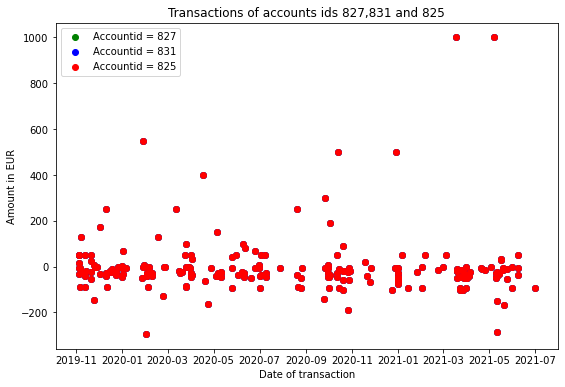

In [31]:
# Graphical Plots of transactions of accounts ids 827,831 and 825
plt.figure(figsize=(9, 6))
plt.scatter(
    transactions[transactions["account_id"] == 827]["date"],
    transactions[transactions["account_id"] == 827]["amount"],
    color="green",
    label="Accountid = 827",
)

plt.scatter(
    transactions[transactions["account_id"] == 831]["date"],
    transactions[transactions["account_id"] == 831]["amount"],
    color="blue",
    label="Accountid = 831",
)

plt.scatter(
    transactions[transactions["account_id"] == 825]["date"],
    transactions[transactions["account_id"] == 825]["amount"],
    color="red",
    label="Accountid = 825",
)

plt.legend()
plt.title("Transactions of accounts ids 827,831 and 825")
plt.xlabel("Date of transaction")
plt.ylabel("Amount in EUR")
plt.show()

In the graph above, we plot the amount of transactions in EUR with respect to the date of transactions.
We notice that the three graphs are the same. There is very little probability to have two different accounts that do the same transactions in the same day for a long period of time with the same pattern. Unless they are two different accounts but with regular incomes and expenses.

I will do the assumption that if I have this kind of similarity in transactions, that means that they belong to the same account and that they are duplicates in the dataset. We will remove them from df_account_transactions.

In [32]:
# Remove duplicate accounts from df_account_transactions
df_account_transactions = df_account_transactions[
    -df_account_transactions["id"].isin(potential_duplicates.id)
]

In [33]:
df_account_transactions

,id,min_amount_transaction,max_amount_transaction,nb_transactions,min_history,max_history,balance_account,duration_history,update_date,sum_amount_transactions,old_balance_account
0,0,-3000.0,3000.0,310,2020-10-16,2021-06-30,13.63,257 days,2021-07-02,-2.21,15.84
1,1,-5100.0,5110.1,105,2020-11-09,2021-06-28,12.91,231 days,2021-07-02,102.88,-89.97
2,4,-2940.0,2643.0,1041,2020-09-11,2021-07-01,2806.75,293 days,2021-07-02,2786.75,20.00
3,7,-2547.0,1839.4,668,2020-03-09,2021-07-01,0.38,479 days,2021-07-02,0.38,0.00
4,8,-1160.0,1100.0,761,2019-07-24,2021-06-30,25.04,707 days,2021-07-02,57.51,-32.47
...,...,...,...,...,...,...,...,...,...,...,...
804,1247,-5610.0,5820.0,1091,2020-04-29,2021-07-01,688.03,428 days,2021-07-02,782.14,-94.11
806,1249,-1597.0,5000.0,452,2018-06-27,2021-06-29,5117.09,1098 days,2021-07-02,-4882.91,10000.00
807,1250,-5100.0,5500.0,484,2020-05-20,2021-07-01,-2952.06,407 days,2021-07-02,45399.30,-48351.36
808,1251,-3000.0,4000.0,955,2020-04-29,2021-07-01,361.86,428 days,2021-07-02,-38089.74,38451.60


We moved from 824 to 733 rows. 

91 rows are duplicated. We will remove these duplicated accounts id from df as well.

In [34]:
# Remove duplicate accounts ids from df, accounts and transactions
df = df[-df["id"].isin(potential_duplicates.id)]
accounts = accounts[-accounts["id"].isin(potential_duplicates.id)]
transactions = transactions[-transactions["account_id"].isin(potential_duplicates.id)]

## Visualisations

In this part, we will do some visualisations. First let's see the distribution of accounts balances. 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


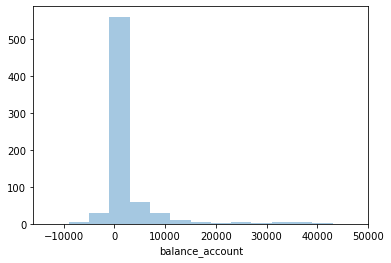

In [35]:
sns.distplot(df_account_transactions.balance_account, bins=15, kde=False)
plt.show()

According to the website of Mansa, the maximum advance amount that mansa lend is 20000 EUR.
The histogram shows that some balance values are higher than 40000 EUR. Let's see how many accounts 
have balances that are more than 40000 EUR. 


In [54]:
df_account_transactions[df_account_transactions["balance_account"] >= 40000]

,id,min_amount_transaction,max_amount_transaction,nb_transactions,min_history,max_history,balance_account,duration_history,update_date,sum_amount_transactions,old_balance_account
63,110,-5830.0,5460.0,1000,2020-07-28,2021-07-01,42974.05,338 days,2021-07-02,-97473.62,140447.67
84,150,-5000.0,4500.0,333,2020-11-17,2021-07-01,47025.47,226 days,2021-07-02,-150810.54,197836.01
296,520,-4279.0,5000.0,507,2020-02-03,2021-06-30,40232.71,513 days,2021-07-02,39932.71,300.00


Three accounts have more than 40000 EUR as account balance at the time of update date. 
We will plot the transactions of these three accounts to have an idea about them, and compare them
with transactions of a normal account id, for example account id 4. 

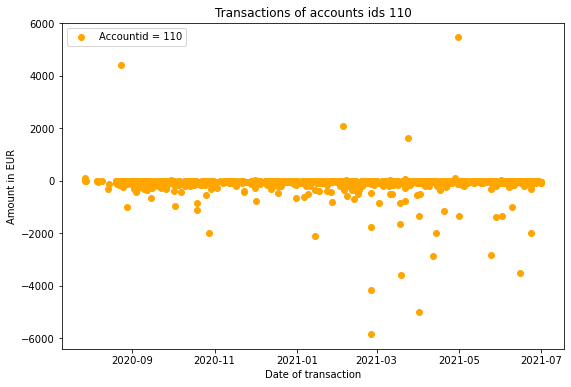

In [55]:
# Graphical Plots of transactions of accounts id 110
plt.figure(figsize=(9, 6))
plt.scatter(
    transactions[transactions["account_id"] == 110]["date"],
    transactions[transactions["account_id"] == 110]["amount"],
    color="orange",
    label="Accountid = 110",
)


plt.legend()
plt.title("Transactions of accounts ids 110")
plt.xlabel("Date of transaction")
plt.ylabel("Amount in EUR")
plt.show()

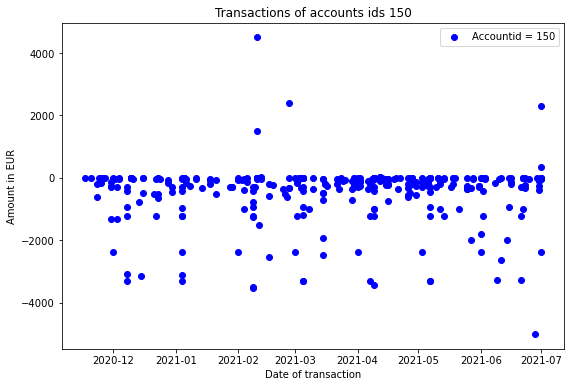

In [56]:
# Graphical Plots of transactions of accounts id 150
plt.figure(figsize=(9, 6))
plt.scatter(
    transactions[transactions["account_id"] == 150]["date"],
    transactions[transactions["account_id"] == 150]["amount"],
    color="blue",
    label="Accountid = 150",
)


plt.legend()
plt.title("Transactions of accounts ids 150")
plt.xlabel("Date of transaction")
plt.ylabel("Amount in EUR")
plt.show()

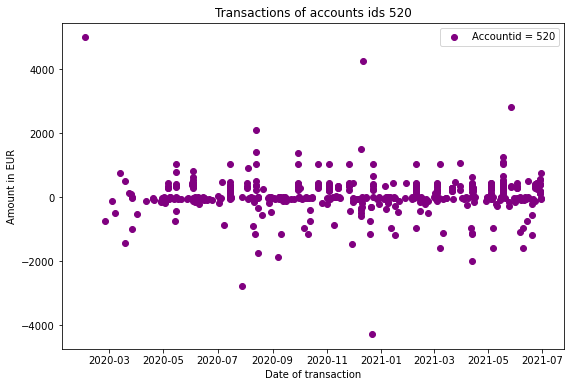

In [60]:
# Graphical Plots of transactions of accounts id 520
plt.figure(figsize=(9, 6))
plt.scatter(
    transactions[transactions["account_id"] == 520]["date"],
    transactions[transactions["account_id"] == 520]["amount"],
    color="purple",
    label="Accountid = 520",
)


plt.legend()
plt.title("Transactions of accounts ids 520")
plt.xlabel("Date of transaction")
plt.ylabel("Amount in EUR")
plt.show()

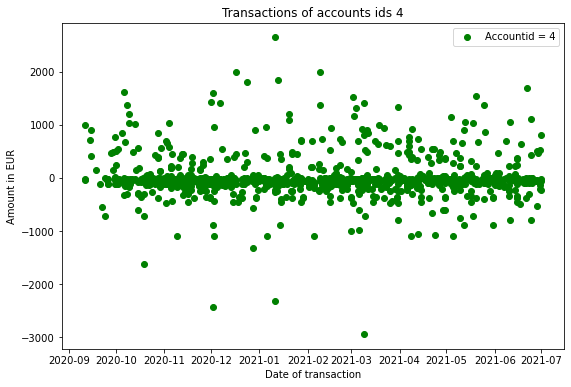

In [61]:
# Graphical Plots of transactions of accounts id 4
plt.figure(figsize=(9, 6))
plt.scatter(
    transactions[transactions["account_id"] == 4]["date"],
    transactions[transactions["account_id"] == 4]["amount"],
    color="green",
    label="Accountid = 4",
)


plt.legend()
plt.title("Transactions of accounts ids 4")
plt.xlabel("Date of transaction")
plt.ylabel("Amount in EUR")
plt.show()

When compared to account 4, the three accounts seem to have normal transactions in a normal range of income and outgoing. Except for some few  transactions which are very high. I won't remove them from data.

In [40]:
def summary_df_by_year(df):
    df_account_transactions_by_year = (
        df.groupby(["id", df.index.year])["amount"]
        .agg(["min", "max", "mean", "count"])
        .reset_index()
        .rename(
            columns={
                "min": "min_amount_transaction",
                "max": "max_amount_transaction",
                "mean": "mean_amount_transaction",
                "count": "nb_transactions_per_year",
                "date": "year",
            }
        )
    )

    return df_account_transactions_by_year

In [41]:
def summary_df_by_month(df):
    df_account_transactions_by_month = (
        df.groupby(["id", df.index.month])["amount"]
        .agg(["min", "max", "mean", "count"])
        .reset_index()
        .rename(
            columns={
                "min": "min_amount_transaction",
                "max": "max_amount_transaction",
                "mean": "mean_amount_transaction",
                "count": "nb_transactions_per_month",
                "date": "month",
            }
        )
    )

    return df_account_transactions_by_month

In [42]:
df_account_transactions_by_year = summary_df_by_year(df)

In [43]:
df_account_transactions_by_month = summary_df_by_month(df)

In [48]:
nb_transaction_year = (
    df_account_transactions_by_year.groupby(["year"])["nb_transactions_per_year"]
    .agg(["sum"])
    .reset_index()
)

In [49]:
nb_transaction_month = (
    df_account_transactions_by_month.groupby(["month"])["nb_transactions_per_month"]
    .agg(["sum"])
    .reset_index()
)

In [50]:
nb_transaction_year.set_index("year", inplace=True)
nb_transaction_month.set_index("month", inplace=True)

Text(0.5, 1.0, 'Number of transactions per year')

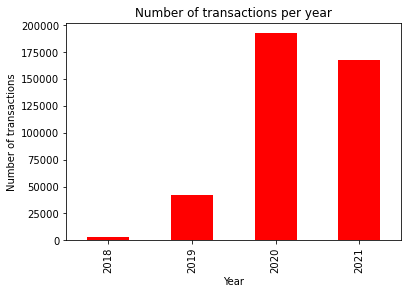

In [51]:
# show number of transactions per year
nb_transaction_year["sum"].plot(kind="bar", color="red")
plt.xlabel("Year")
plt.ylabel("Number of transactions")
plt.title("Number of transactions per year")

Text(0.5, 1.0, 'Number of transactions per month')

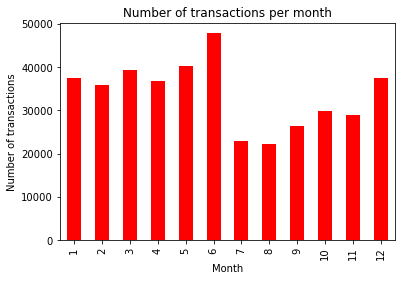

In [52]:
# show number of transactions per year
nb_transaction_month["sum"].plot(kind="bar", color="red")
plt.xlabel("Month")
plt.ylabel("Number of transactions")
plt.title("Number of transactions per month")

## Save data

In [53]:
# Save new data without duplicates
df.to_csv("../data/no_duplicates_data.csv", index=True)
accounts.to_csv("../data/no_duplicates_accounts.csv", index=False)
transactions.to_csv("../data/no_duplicates_transactions.csv", index=False)